# House Prices Predicting

In [1]:
from IPython.display import display
pd.options.display.max_columns = None

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from scipy import stats
from scipy.stats import skew,norm

import statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor


### 데이터 불러오기 및 정리

In [2]:
# 데이터 불러오기
df_origin = pd.read_csv('train.csv')

In [3]:
# 컬럼 확인
df_origin.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
len(df_origin.columns)

81

In [5]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
# 분석에 필요없는 컬럼 'Id' 제외 및 타겟 변수 'SalePrice' 분리
df = df_origin.drop(['Id','SalePrice'], axis=1)
y = df_origin['SalePrice']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [8]:
# 예측값인 'SalePrice' 컬럼 내역 확인
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to NanumBarunGothic.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to NanumBarunGothic.
  (prop.get_family(), self.defaultFamily[fontext]))


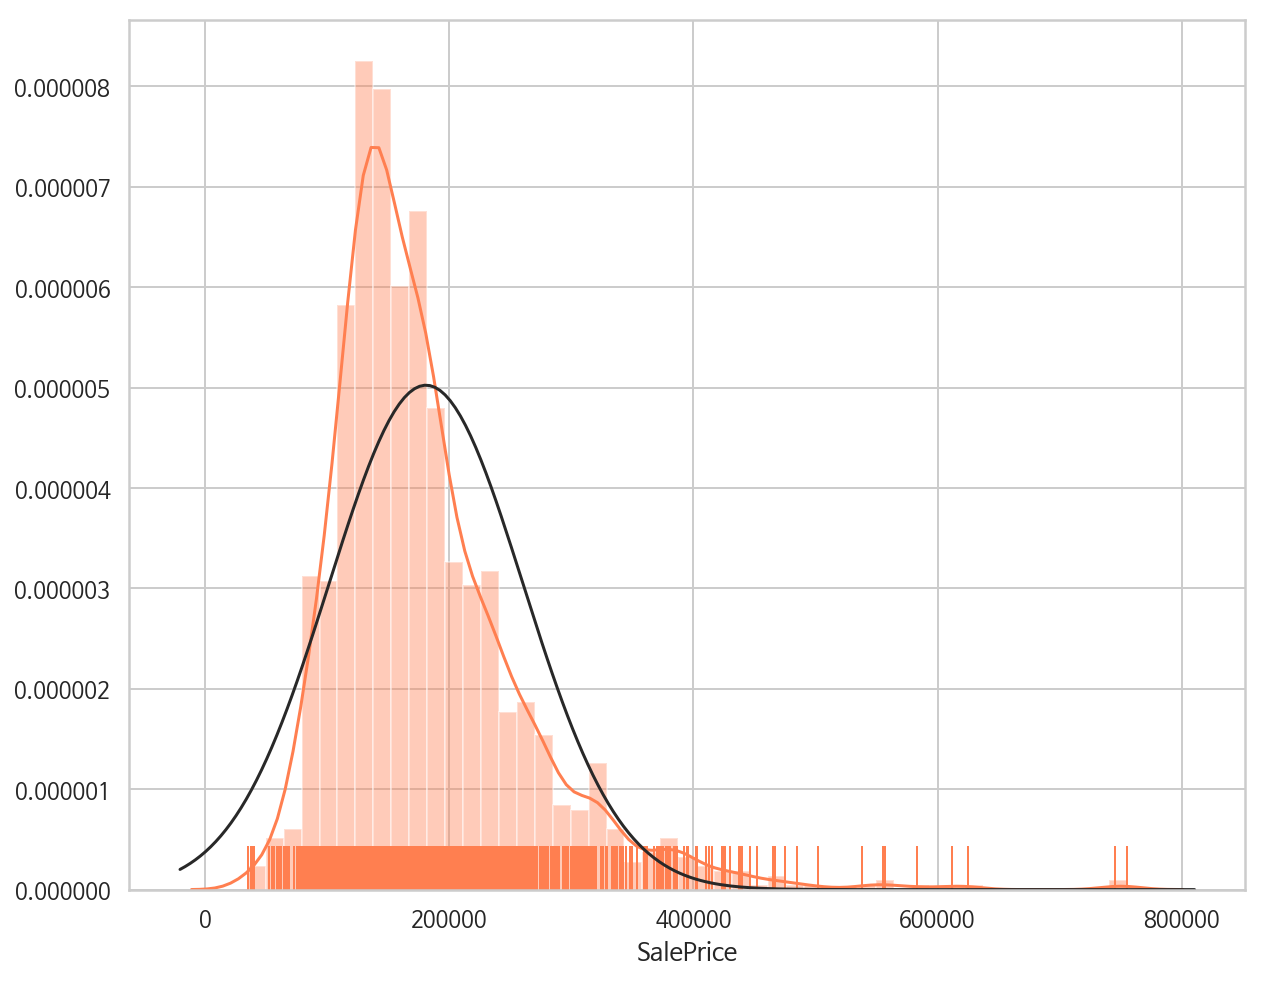

In [9]:
plt.figure(figsize=(10,8))
sns.distplot(y, color='coral', fit=norm, rug=True)

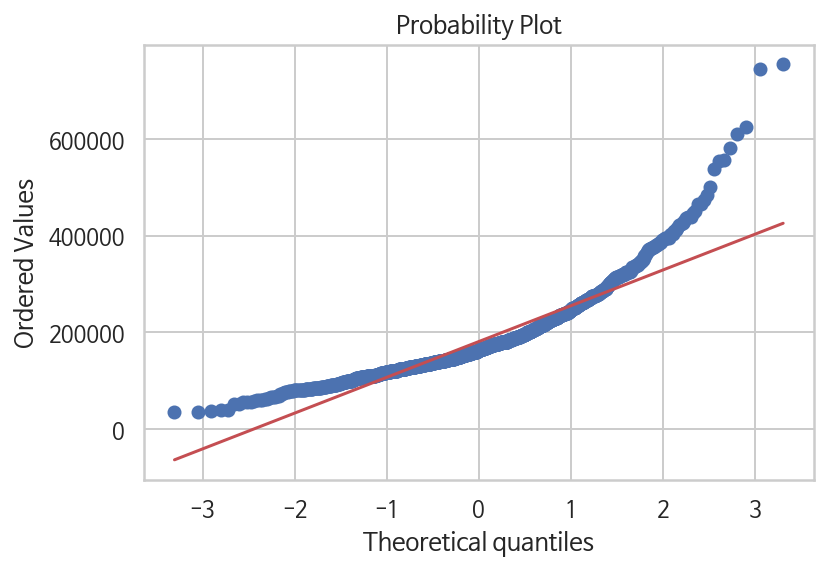

In [10]:
# normal distribution check
res = stats.probplot(y, plot=plt)

### 데이터 상관관계

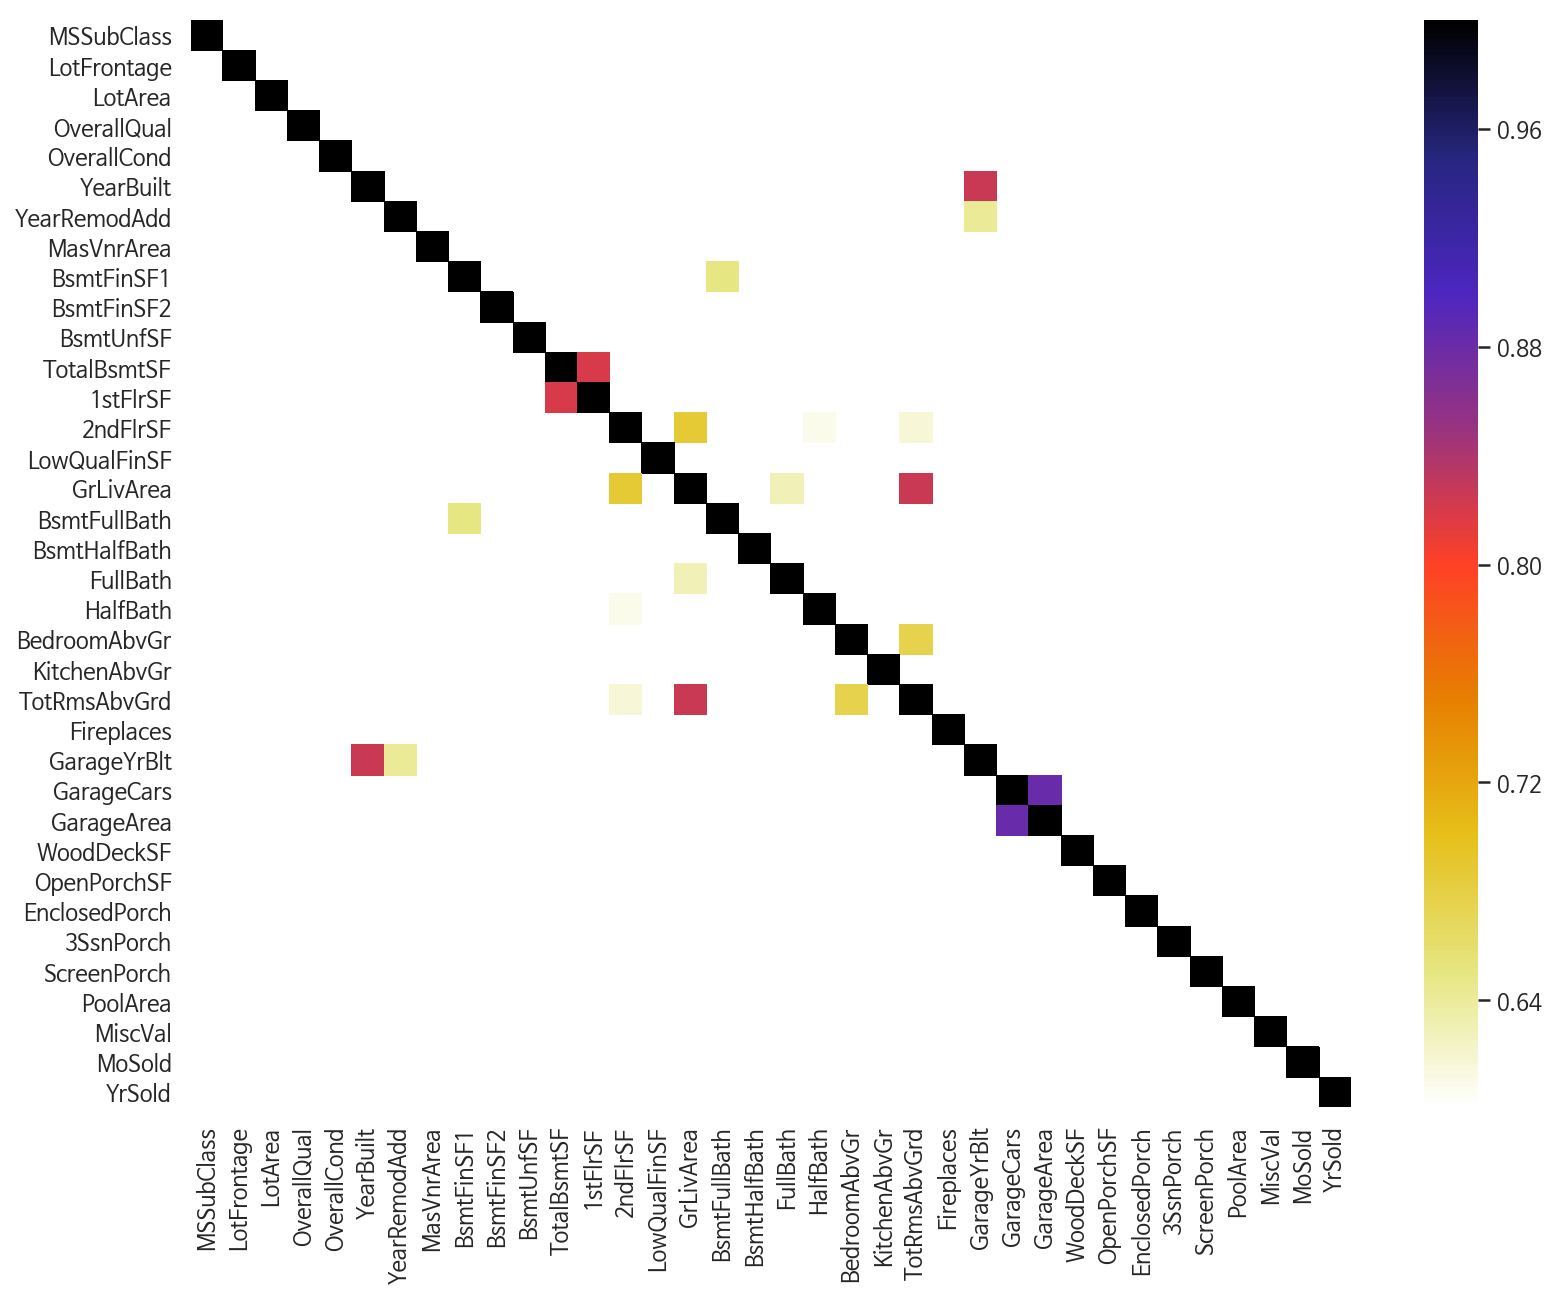

In [11]:
# 숫자형 변수끼리의 전체 상관관계 히트맵
plt.figure(figsize=(13,10))
df_corr = df.corr()
df_corr = df_corr.where(df_corr >= 0,   -df_corr) # 음의 상관관계에서도 높은 상관계수를 갖은 데이터를 히트맵으로 보기 위해 음수를 양수로 변경
sns.heatmap(df_corr.where(df_corr > 0.6), cmap="CMRmap_r") # 상관계수가 0.6 이상인 값만 히트맵에 표시

In [12]:
# 상관계수가 높은 조합 리스트
high_corr_list = []
for i in df_corr.columns:
    for j in df_corr.index[df_corr[i] > 0.6]:
        if (i != j) and (not sorted([i,j]) in high_corr_list) :
            high_corr_list.append(sorted([i,j]))
high_corr_list

[['GarageCars', 'OverallQual'],
 ['GarageYrBlt', 'YearBuilt'],
 ['GarageYrBlt', 'YearRemodAdd'],
 ['BsmtFinSF1', 'BsmtFullBath'],
 ['1stFlrSF', 'TotalBsmtSF'],
 ['2ndFlrSF', 'GrLivArea'],
 ['2ndFlrSF', 'HalfBath'],
 ['2ndFlrSF', 'TotRmsAbvGrd'],
 ['FullBath', 'GrLivArea'],
 ['GrLivArea', 'TotRmsAbvGrd'],
 ['BedroomAbvGr', 'TotRmsAbvGrd'],
 ['GarageArea', 'GarageCars']]

상관관계 탑10 리스트:  Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')


/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to NanumBarunGothic.
  (prop.get_family(), self.defaultFamily[fontext]))


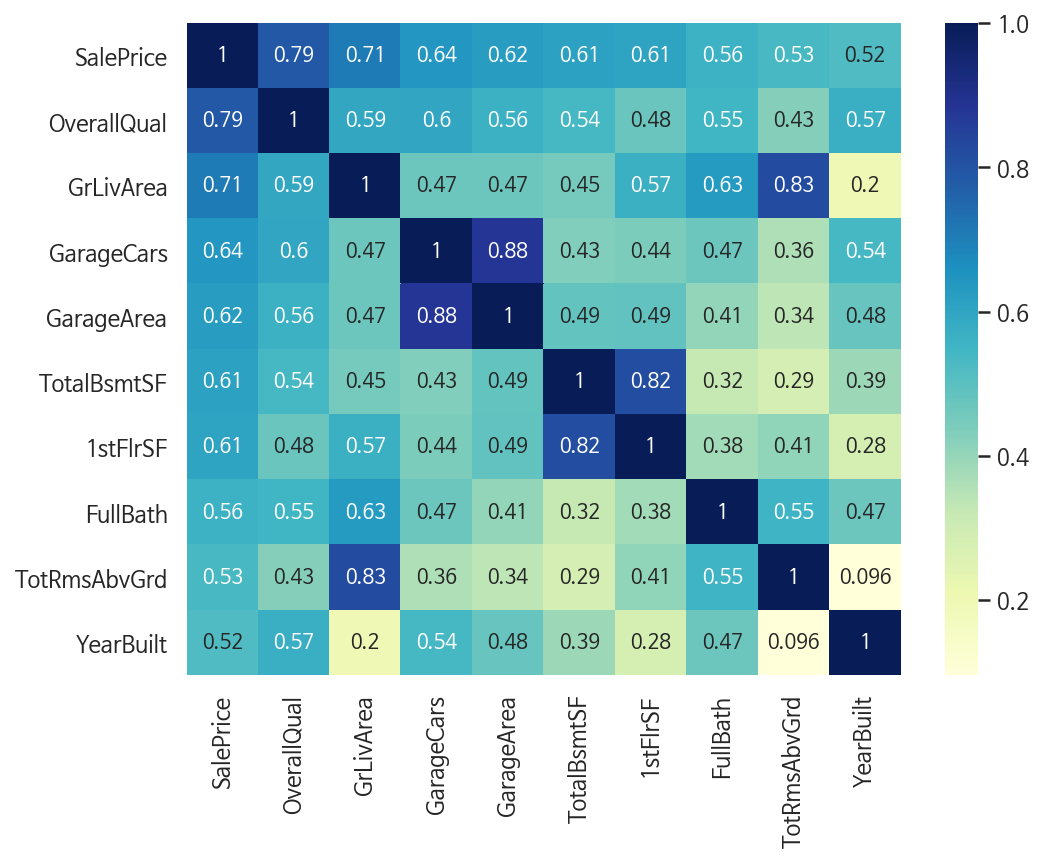

In [13]:
# 'SalePrice' 와 상관관계가 있는 컬럼 상위 10개 분류 
df['SalePrice'] = y
corrlist = df.corr().nlargest(10, 'SalePrice').index
print('상관관계 탑10 리스트: ',corrlist)
plt.figure(figsize=(8,6))
sns.heatmap(df[corrlist].corr(), annot=True, cmap="YlGnBu")
df.drop('SalePrice', axis=1, inplace=True)

## NaN값 처리

In [14]:
# NA값 있는 컬럼 확인 (19개)
col_null = df.count().index[df.count() != 1460]
col_null

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [15]:
# 컬럼별 NA값 내용 확인
na_list = df[col_null]
na_list

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,65.0,NaN,BrkFace,196.0,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,2003.0,RFn,TA,TA,NaN,NaN,NaN
1,80.0,NaN,None,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,1976.0,RFn,TA,TA,NaN,NaN,NaN
2,68.0,NaN,BrkFace,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,2001.0,RFn,TA,TA,NaN,NaN,NaN
3,60.0,NaN,None,0.0,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Detchd,1998.0,Unf,TA,TA,NaN,NaN,NaN
4,84.0,NaN,BrkFace,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,TA,Attchd,2000.0,RFn,TA,TA,NaN,NaN,NaN
5,85.0,NaN,None,0.0,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,1993.0,Unf,TA,TA,NaN,MnPrv,Shed
6,75.0,NaN,Stone,186.0,Ex,TA,Av,GLQ,Unf,SBrkr,Gd,Attchd,2004.0,RFn,TA,TA,NaN,NaN,NaN
7,NaN,NaN,Stone,240.0,Gd,TA,Mn,ALQ,BLQ,SBrkr,TA,Attchd,1973.0,RFn,TA,TA,NaN,NaN,Shed
8,51.0,NaN,None,0.0,TA,TA,No,Unf,Unf,FuseF,TA,Detchd,1931.0,Unf,Fa,TA,NaN,NaN,NaN
9,50.0,NaN,None,0.0,TA,TA,No,GLQ,Unf,SBrkr,TA,Attchd,1939.0,RFn,Gd,TA,NaN,NaN,NaN


In [16]:
# NA처리: LotFrontage (도로와 인접한 쪽 집의 폭)

# NA 값을 미 측정치라고 가정하고 상관관계가 있는 다른 컬럼인 LotArea를 이용하여 두 컬럼의 비율을 적용해 NA 예측값을 대입
Lot_col = df[['LotFrontage','LotArea']]

# LotArea/LotFrontage 값을 Div 컬럼에 넣음
Lot_col['Div'] = Lot_col['LotArea']/Lot_col['LotFrontage']
Lot_col

,LotFrontage,LotArea,Div
0,65.0,8450,130.000000
1,80.0,9600,120.000000
2,68.0,11250,165.441176
3,60.0,9550,159.166667
4,84.0,14260,169.761905
5,85.0,14115,166.058824
6,75.0,10084,134.453333
7,NaN,10382,NaN
8,51.0,6120,120.000000
9,50.0,7420,148.400000


In [17]:
Lot_col['Div'].describe()

count    1201.000000
mean      142.493890
std        82.052885
min        26.915033
25%       115.625000
50%       129.625000
75%       150.000000
max      1434.966667
Name: Div, dtype: float64

In [18]:
print('Div값이 500 이상인 개수: ',len(Lot_col['Div'].dropna()[Lot_col['Div'].dropna() >= 500]))
# 500 을 기준으로 그 이상값들을 아웃라이어로 판단하고 제외
Lot_col['Div'].dropna()[Lot_col['Div'].dropna() < 500].describe()

Div값이 500 이상인 개수:  9


count    1192.000000
mean      137.009788
std        46.211513
min        26.915033
25%       115.500176
50%       129.462166
75%       149.720833
max       446.608696
Name: Div, dtype: float64

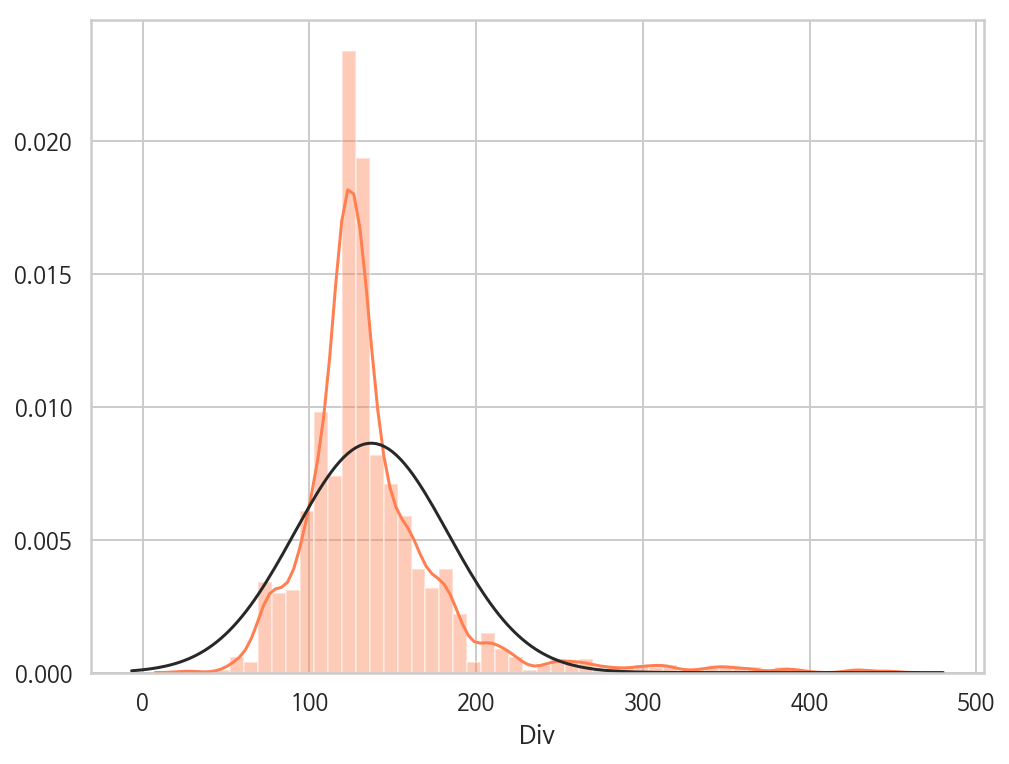

In [19]:
# 아웃라이어를 제외하고 분포그래프로 분포 확인
plt.figure(figsize=(8,6))
sns.distplot(Lot_col['Div'].dropna()[Lot_col['Div'].dropna() < 500], color='coral', fit=norm)

In [20]:
# 분류된 Div컬럼의 평균값을 이용해서 LotFrontage의 NA값을 예측하여 채움
Lot_mean = Lot_col['Div'].dropna()[Lot_col['Div'].dropna() < 500].mean()
na_list['LotFrontage'] = Lot_col['LotFrontage'].fillna(Lot_col['LotArea']/Lot_mean)

print('<처리후 NA 개수>\n',na_list['LotFrontage'].isna().sum())

<처리후 NA 개수>
 0


In [21]:
# NA처리: Alley (현관 들어오는 길 포장타입)
na_col = 'Alley'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값이 의미하는게 들어오는 길 자체가 없는것 이므로 NoAcss로 변경
na_list[na_col] = na_list[na_col].fillna('NoAcss')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 Grvl    50
Pave    41
Name: Alley, dtype: int64

<NA 개수>
 1369

<처리후 Value 종류>
 NoAcss    1369
Grvl        50
Pave        41
Name: Alley, dtype: int64

<처리후 NA 개수>
 0


In [22]:
# NA처리: MasVnrType (골조 벽 덮게 타입) 
na_col = 'MasVnrType'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# 덮게 자체가 없다고 판단하여 None으로 변경
na_list[na_col] = na_list[na_col].fillna('None')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

<NA 개수>
 8

<처리후 Value 종류>
 None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

<처리후 NA 개수>
 0


In [23]:
# NA처리: MasVnrArea (골조 벽 덮게 넓이) 
na_col = 'MasVnrArea'

print('<NA 개수>\n',na_list[na_col].isna().sum())

# MasVnrType을 None으로 바꿨기때문에 넓이도 0으로 변경
na_list[na_col] = na_list[na_col].fillna(0.0)
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<NA 개수>
 8

<처리후 NA 개수>
 0


In [24]:
# NA처리: BsmtQual (지하실 높이 점수)
na_col = 'BsmtQual'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값의 의미가 지하실이 없다는 뜻이므로 NoBsmt로 변경
na_list[na_col] = na_list[na_col].fillna('NoBsmt')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

<NA 개수>
 37

<처리후 Value 종류>
 TA        649
Gd        618
Ex        121
NoBsmt     37
Fa         35
Name: BsmtQual, dtype: int64

<처리후 NA 개수>
 0


In [25]:
# NA처리: BsmtCond (지하실 전체적 점수)
na_col = 'BsmtCond'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값의 의미가 지하실이 없다는 뜻이므로 NoBsmt로 변경
na_list[na_col] = na_list[na_col].fillna('NoBsmt')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

<NA 개수>
 37

<처리후 Value 종류>
 TA        1311
Gd          65
Fa          45
NoBsmt      37
Po           2
Name: BsmtCond, dtype: int64

<처리후 NA 개수>
 0


In [26]:
# NA처리: BsmtExposure (지하실 창문이 외부로 노출된 정도)
na_col = 'BsmtExposure'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값의 의미가 지하실이 없다는 뜻이므로 NoBsmt로 변경
na_list[na_col] = na_list[na_col].fillna('NoBsmt')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

<NA 개수>
 38

<처리후 Value 종류>
 No        953
Av        221
Gd        134
Mn        114
NoBsmt     38
Name: BsmtExposure, dtype: int64

<처리후 NA 개수>
 0


In [27]:
# NA처리: BsmtFinType1 (지하실 거주 가능 점수)
na_col = 'BsmtFinType1'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값의 의미가 지하실이 없다는 뜻이므로 NoBsmt로 변경
na_list[na_col] = na_list[na_col].fillna('NoBsmt')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

<NA 개수>
 37

<처리후 Value 종류>
 Unf       430
GLQ       418
ALQ       220
BLQ       148
Rec       133
LwQ        74
NoBsmt     37
Name: BsmtFinType1, dtype: int64

<처리후 NA 개수>
 0


In [28]:
# NA처리: BsmtFinType2 (지하실 거주 가능 점수, 여러 종류일경우)
na_col = 'BsmtFinType2'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값의 의미가 지하실이 없다는 뜻이므로 NoBsmt로 변경
na_list[na_col] = na_list[na_col].fillna('NoBsmt')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

<NA 개수>
 38

<처리후 Value 종류>
 Unf       1256
Rec         54
LwQ         46
NoBsmt      38
BLQ         33
ALQ         19
GLQ         14
Name: BsmtFinType2, dtype: int64

<처리후 NA 개수>
 0


In [29]:
# NA처리: Electrical (전력 시스템 관련)
na_col = 'Electrical'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# 정보를 알수 없기때문에 새로운 카테고리 None 생성
na_list[na_col] = na_list[na_col].fillna('None')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

<NA 개수>
 1

<처리후 Value 종류>
 SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
None        1
Name: Electrical, dtype: int64

<처리후 NA 개수>
 0


In [30]:
# NA처리: FireplaceQu (벽난로 퀄리티)
na_col = 'FireplaceQu'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값의 의미가 벽난로가 없다는 뜻이므로 NoF로 변경
na_list[na_col] = na_list[na_col].fillna('NoF')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

<NA 개수>
 690

<처리후 Value 종류>
 NoF    690
Gd     380
TA     313
Fa      33
Ex      24
Po      20
Name: FireplaceQu, dtype: int64

<처리후 NA 개수>
 0


In [31]:
# NA처리: GarageType (차고 위치)
na_col = 'GarageType'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값의 의미가 차고가 없다는 뜻이므로 NoGrage로 변경
na_list[na_col] = na_list[na_col].fillna('NoGrage')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

<NA 개수>
 81

<처리후 Value 종류>
 Attchd     870
Detchd     387
BuiltIn     88
NoGrage     81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

<처리후 NA 개수>
 0


In [32]:
# NA처리: GarageYrBlt (차고 지어진 년도)
na_col = 'GarageYrBlt'

print('<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값의 의미가 차고가 없다는 뜻이므로 NoGrage로 변경
na_list[na_col] = na_list[na_col].fillna('NoGrage')
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<NA 개수>
 81

<처리후 NA 개수>
 0


In [33]:
# NA처리: GarageFinish (차고 내부 인테리어 완성정도)
na_col = 'GarageFinish'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값의 의미가 차고가 없다는 뜻이므로 NoGrage로 변경
na_list[na_col] = na_list[na_col].fillna('NoGrage')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

<NA 개수>
 81

<처리후 Value 종류>
 Unf        605
RFn        422
Fin        352
NoGrage     81
Name: GarageFinish, dtype: int64

<처리후 NA 개수>
 0


In [34]:
# NA처리: GarageQual (차고 퀄리티)
na_col = 'GarageQual'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값의 의미가 차고가 없다는 뜻이므로 NoGrage로 변경
na_list[na_col] = na_list[na_col].fillna('NoGrage')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64

<NA 개수>
 81

<처리후 Value 종류>
 TA         1311
NoGrage      81
Fa           48
Gd           14
Ex            3
Po            3
Name: GarageQual, dtype: int64

<처리후 NA 개수>
 0


In [35]:
# NA처리: GarageCond (차고 상태)
na_col = 'GarageCond'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값의 의미가 차고가 없다는 뜻이므로 NoGrage로 변경
na_list[na_col] = na_list[na_col].fillna('NoGrage')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

<NA 개수>
 81

<처리후 Value 종류>
 TA         1326
NoGrage      81
Fa           35
Gd            9
Po            7
Ex            2
Name: GarageCond, dtype: int64

<처리후 NA 개수>
 0


In [36]:
# NA처리: PoolQC (수영장 퀄리티)
na_col = 'PoolQC'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값의 의미가 수영장이 없다는 뜻이므로 NoPool로 변경
na_list[na_col] = na_list[na_col].fillna('NoPool')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

<NA 개수>
 1453

<처리후 Value 종류>
 NoPool    1453
Gd           3
Ex           2
Fa           2
Name: PoolQC, dtype: int64

<처리후 NA 개수>
 0


In [37]:
# NA처리: Fence (울타리 퀄리티)
na_col = 'Fence'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값의 의미가 울타리가 없다는 뜻이므로 NoFnc로 변경
na_list[na_col] = na_list[na_col].fillna('NoFnc')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

<NA 개수>
 1179

<처리후 Value 종류>
 NoFnc    1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

<처리후 NA 개수>
 0


In [38]:
# NA처리: MiscFeature (기타 특징들)
na_col = 'MiscFeature'

print('<Value 종류>\n',na_list[na_col].value_counts())
print('\n<NA 개수>\n',na_list[na_col].isna().sum())

# NA 값의 의미가 기타 특징이 없다는 뜻이므로 Nothing로 변경
na_list[na_col] = na_list[na_col].fillna('Nothing')
print('\n<처리후 Value 종류>\n',na_list[na_col].value_counts())
print('\n<처리후 NA 개수>\n',na_list[na_col].isna().sum())

<Value 종류>
 Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

<NA 개수>
 1406

<처리후 Value 종류>
 Nothing    1406
Shed         49
Othr          2
Gar2          2
TenC          1
Name: MiscFeature, dtype: int64

<처리후 NA 개수>
 0


In [39]:
# 전체 NA 처리 확인
na_list.isna().sum()

LotFrontage     0
Alley           0
MasVnrType      0
MasVnrArea      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

In [40]:
# df 으로 NA값 정리한 데이터 이동
for i in col_null:
    df[i] = na_list[i]
df.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
                ..
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea    

### categorical와 quantitative 항목 분류

In [41]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NoAcss,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NoF,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NoPool,NoFnc,Nothing,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NoAcss,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NoPool,NoFnc,Nothing,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NoAcss,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NoPool,NoFnc,Nothing,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NoAcss,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NoPool,NoFnc,Nothing,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NoAcss,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NoPool,NoFnc,Nothing,0,12,2008,WD,Normal


In [42]:
col_cat = []
col_quan = []
for i in df.columns:
    if df[i].dtype == 'object':
        col_cat.append(i)
    else:
        col_quan.append(i)
# 범주형 컬럼 개수
print(len(col_cat))
# 숫자형 컬럼 개수
print(len(col_quan))
    

44
35


### 각 컬럼별 분석 및 수정

In [43]:
df[col_quan]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.000000,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008
1,20,80.000000,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007
2,60,68.000000,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008
3,70,60.000000,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006
4,60,84.000000,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008
5,50,85.000000,14115,5,5,1993,1995,0.0,732,0,64,796,796,566,0,1362,1,0,1,1,1,1,5,0,2,480,40,30,0,320,0,0,700,10,2009
6,20,75.000000,10084,8,5,2004,2005,186.0,1369,0,317,1686,1694,0,0,1694,1,0,2,0,3,1,7,1,2,636,255,57,0,0,0,0,0,8,2007
7,60,75.775608,10382,7,6,1973,1973,240.0,859,32,216,1107,1107,983,0,2090,1,0,2,1,3,1,7,2,2,484,235,204,228,0,0,0,350,11,2009
8,50,51.000000,6120,7,5,1931,1950,0.0,0,0,952,952,1022,752,0,1774,0,0,2,0,2,2,8,2,2,468,90,0,205,0,0,0,0,4,2008
9,190,50.000000,7420,5,6,1939,1950,0.0,851,0,140,991,1077,0,0,1077,1,0,1,0,2,2,5,2,1,205,0,4,0,0,0,0,0,1,2008


In [44]:
# MSSubClass : 주거 타입 (범주형으로 수정하기)
'''
        20	1-STORY 1946 & NEWER ALL STYLES -> S1NEW
        30	1-STORY 1945 & OLDER -> S1OLD
        40	1-STORY W/FINISHED ATTIC ALL AGES -> S1FA
        45	1-1/2 STORY - UNFINISHED ALL AGES -> S1hUFA
        50	1-1/2 STORY FINISHED ALL AGES -> S1hFA
        60	2-STORY 1946 & NEWER -> S2NEW
        70	2-STORY 1945 & OLDER -> S2OLD
        75	2-1/2 STORY ALL AGES -> S2h
        80	SPLIT OR MULTI-LEVEL -> SML
        85	SPLIT FOYER -> SF
        90	DUPLEX - ALL STYLES AND AGES -> DPL
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER -> S1PNEW
       150	1-1/2 STORY PUD - ALL AGES -> S1hSP
       160	2-STORY PUD - 1946 & NEWER -> S2PNEW
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER -> PMI
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES -> F2
'''

df['MSSubClass'] = np.select([df['MSSubClass']==20,
                                   df['MSSubClass']==30,df['MSSubClass']==40,
                                   df['MSSubClass']==45,df['MSSubClass']==50,
                                   df['MSSubClass']==60,df['MSSubClass']==70,
                                   df['MSSubClass']==75,df['MSSubClass']==80,
                                   df['MSSubClass']==85,df['MSSubClass']==90,
                                   df['MSSubClass']==120,df['MSSubClass']==150,
                                   df['MSSubClass']==160,df['MSSubClass']==180,
                                   df['MSSubClass']==190,], ['S1NEW', 'S1OLD', 'S1FA', 'S1hUFA', 'S1hFA', 'S2NEW', 'S2OLD',
                                                                    'S2h', 'SML', 'SF', 'DPL', 'S1PNEW', 'S1hSP', 'S2PNEW', 'PMI', 'F2'])
col_cat.append(col_quan.pop(0))
df[col_cat].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass
0,RL,Pave,NoAcss,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NoF,Attchd,2003,RFn,TA,TA,Y,NoPool,NoFnc,Nothing,WD,Normal,S2NEW
1,RL,Pave,NoAcss,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,1976,RFn,TA,TA,Y,NoPool,NoFnc,Nothing,WD,Normal,S1NEW
2,RL,Pave,NoAcss,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,2001,RFn,TA,TA,Y,NoPool,NoFnc,Nothing,WD,Normal,S2NEW
3,RL,Pave,NoAcss,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,1998,Unf,TA,TA,Y,NoPool,NoFnc,Nothing,WD,Abnorml,S2OLD
4,RL,Pave,NoAcss,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,2000,RFn,TA,TA,Y,NoPool,NoFnc,Nothing,WD,Normal,S2NEW


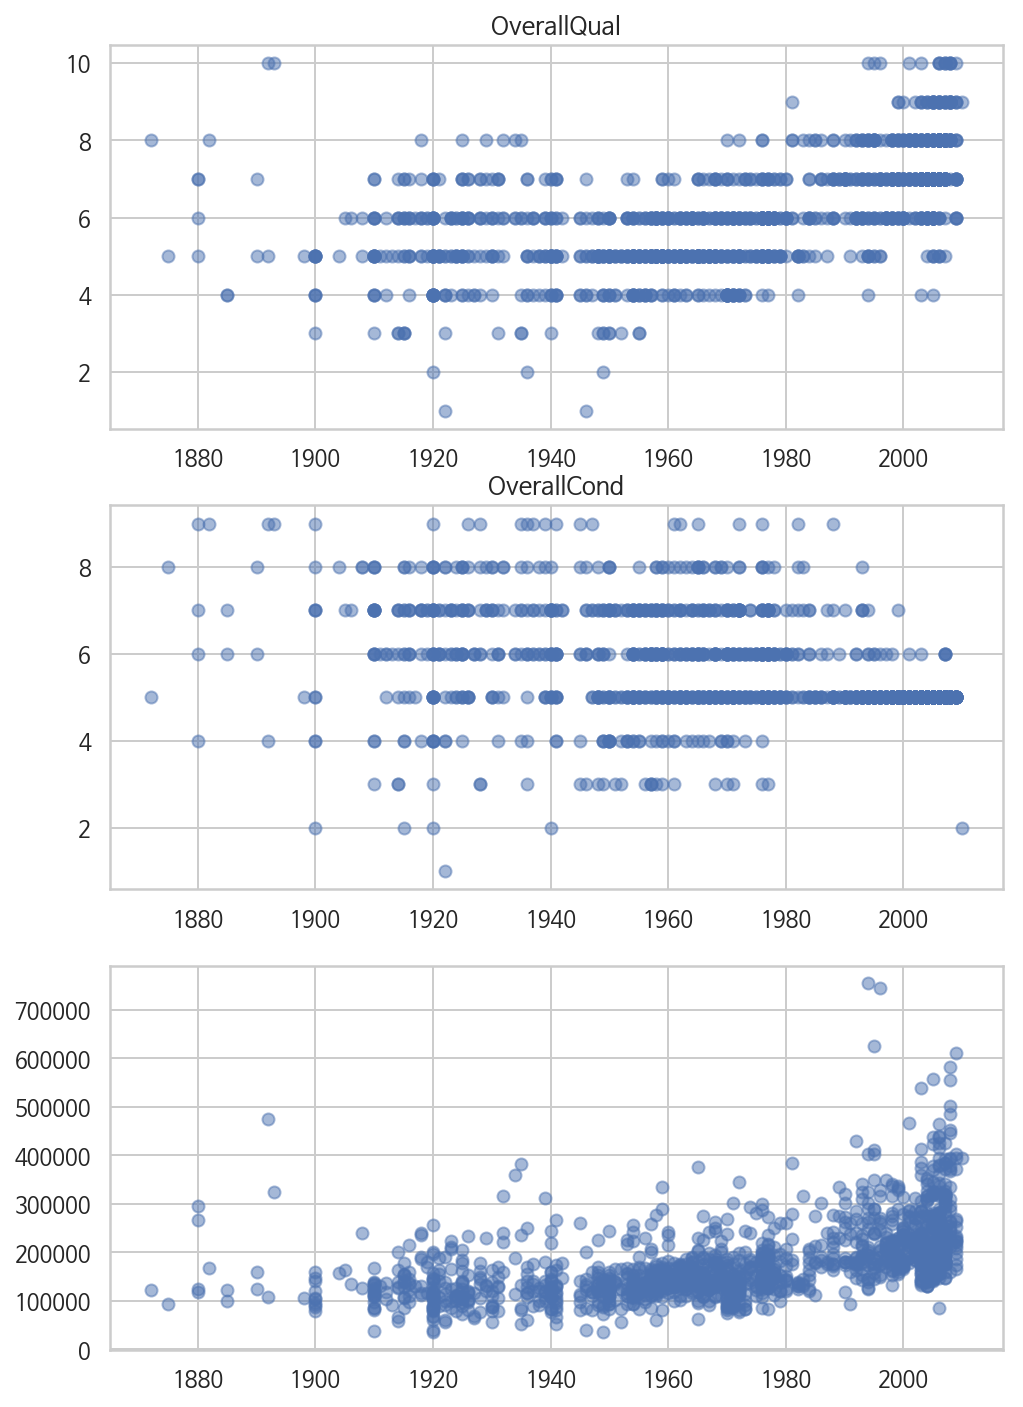

In [45]:
# OverallQual, OverallCond, YearBuilt, YearRemodAdd
plt.figure(figsize=(8,12))
ax1 = plt.subplot(3,1,1)
ax1.scatter(x=df['YearBuilt'], y=df['OverallQual'], alpha=0.5)
ax1.set_title('OverallQual')
ax2 = plt.subplot(3,1,2)
ax2.scatter(x=df['YearBuilt'], y=df['OverallCond'], alpha=0.5)
ax2.set_title('OverallCond')
ax3 = plt.subplot(3,1,3)
ax3.scatter(x=df['YearBuilt'], y=y, alpha=0.5)

(array([187.,  33.,  34.,  38.,  38.,  46.,  57.,  49.,  47.,  51.,  27.,
         21.,  24.,  40.,  58.,  92., 121., 120., 232., 145.]),
 array([1950., 1953., 1956., 1959., 1962., 1965., 1968., 1971., 1974.,
        1977., 1980., 1983., 1986., 1989., 1992., 1995., 1998., 2001.,
        2004., 2007., 2010.]),
 <a list of 20 Patch objects>)

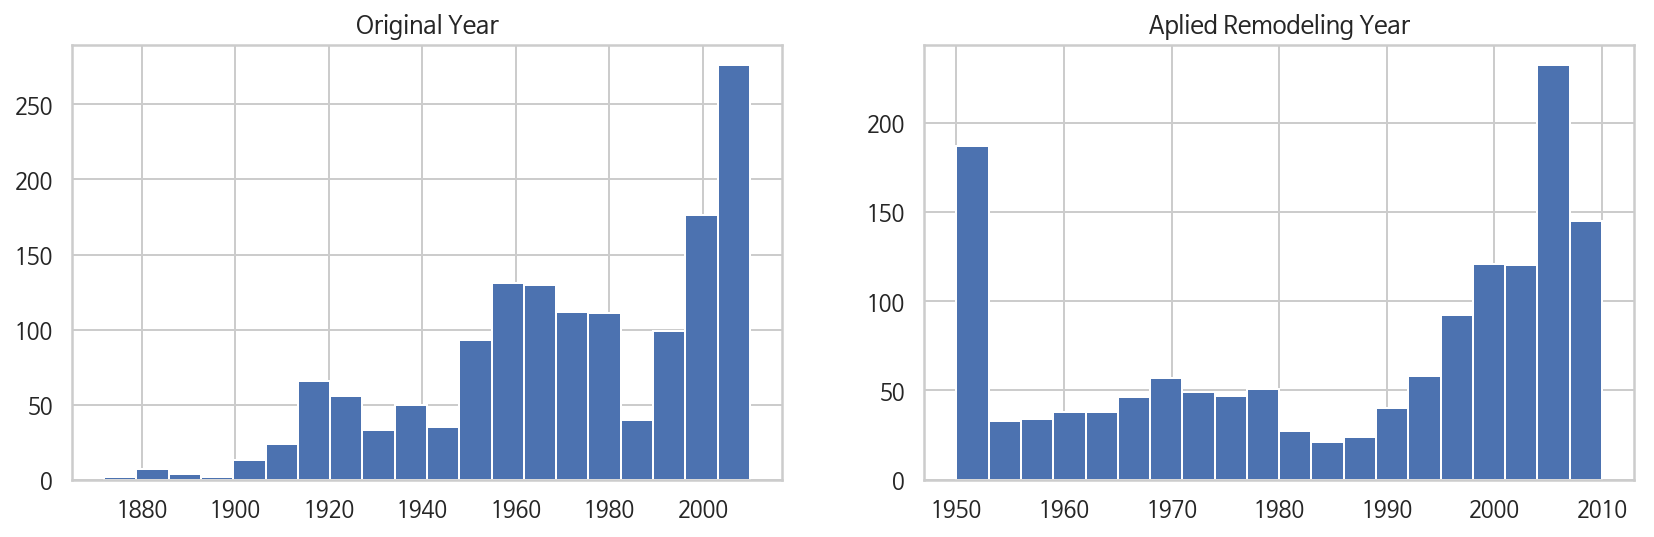

In [46]:
plt.figure(figsize=(14, 4))
ax1 = plt.subplot(121)
ax1.set_title('Original Year')
ax1.hist(df['YearBuilt'],bins=20)
ax2 = plt.subplot(122)
ax2.set_title('Aplied Remodeling Year')
ax2.hist(df['YearRemodAdd'],bins=20)

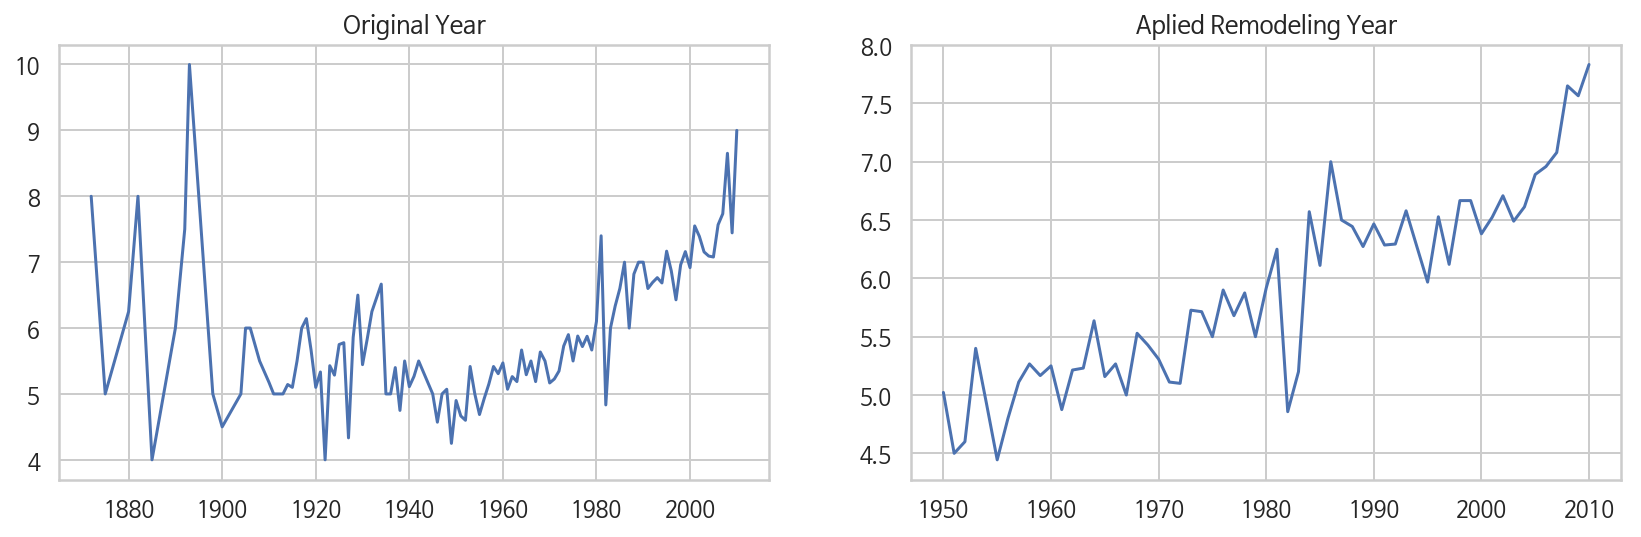

In [47]:
# 1950년 전으로는 데이터 양이 적고 이상치 때문에 평균값 그래프가 일정하지 않음
# 1950년 이후로는 최신 지어진 집 일수록 평점이 높은 경향이 있음
# 리모델링 연식으로 그래프를 그려보면 최신식 일 수록 평점이 높아지는 것을 볼 수 있음
plt.figure(figsize=(14, 4))
ax1 = plt.subplot(121)
ax1.set_title('Original Year')
ax1.plot(df.groupby('YearBuilt')['OverallQual'].mean())
ax2 = plt.subplot(122)
ax2.set_title('Aplied Remodeling Year')
ax2.plot(df.groupby('YearRemodAdd')['OverallQual'].mean())

In [48]:
# 리모델링 연식으로 구하는식이 좀 더 적합하고 오리지날 연식도 포함 하므로 오리지날 연식 데이터를 제외
df = df.drop('YearBuilt', axis=1)
len(df.columns)

78

In [49]:
# MasVnrType이 None(없음)인데 MasVnrArea 값이 존재하는 행 검색
df[df['MasVnrType'] == 'None'][['MasVnrType','MasVnrArea']][df[df['MasVnrType'] == 'None']['MasVnrArea']!=0]

,MasVnrType,MasVnrArea
624,None,288.0
773,None,1.0
1230,None,1.0
1300,None,344.0
1334,None,312.0


In [50]:
# 검색된 값을 0으로 변환
MVT_index = df[df['MasVnrType'] == 'None'][['MasVnrType','MasVnrArea']][df[df['MasVnrType'] == 'None']['MasVnrArea']!=0].index
df.loc[MVT_index,'MasVnrArea'] = 0.0

In [51]:
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF
# 전체 지하실 넓이를 나타내는 TotalBsmtSF만 남기고 분석에서 제외
df = df.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], axis=1)
len(df.columns)

75

In [52]:
# 1stFlrSF, 2ndFlrSF, GrLivArea
# 층별 넓이를 나눠서 나타내주는것이 적합하다고 판단하여 GrLivArea 컬럼을 제외
df = df.drop(['GrLivArea'], axis=1)
len(df.columns)

74

In [53]:
# 컬럼이름이 숫자로 시작하는 컬럼 이름을 영문으로 시작하도록 변경
df.rename(columns={'1stFlrSF':'FstFlrSF','2ndFlrSF':'SndFlrSF'}, inplace=True)

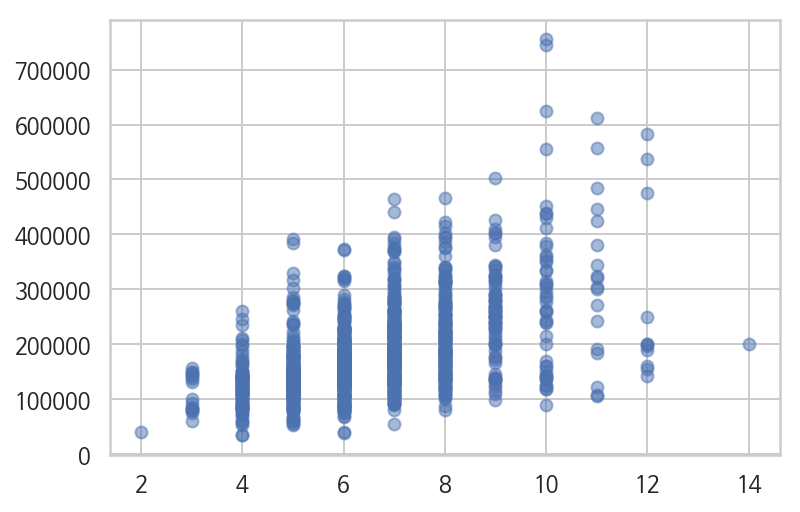

In [54]:
# TotRmsAbvGrd
# 지상에 있는 방 개수별 SalePrice 분포 확인
plt.scatter(x=df['TotRmsAbvGrd'], y=y, alpha=0.5)

In [55]:
# 다중공선성 문제 가능성
df_origin[['GrLivArea','TotRmsAbvGrd']].corr()

,GrLivArea,TotRmsAbvGrd
GrLivArea,1.000000,0.825489
TotRmsAbvGrd,0.825489,1.000000


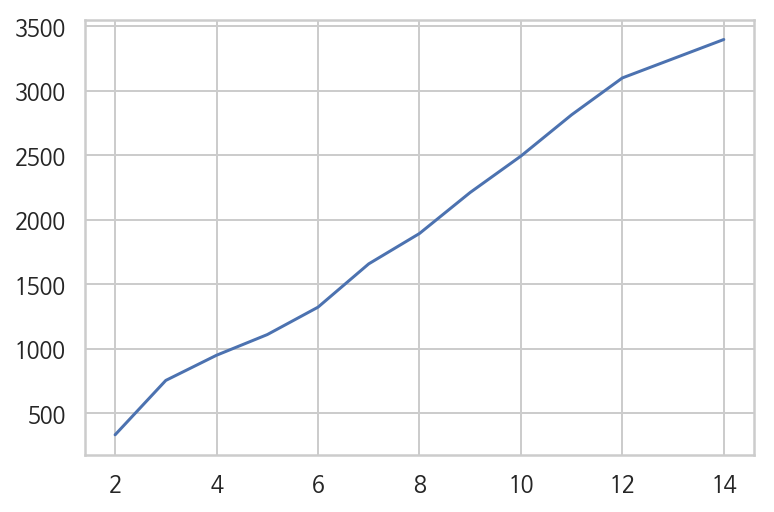

In [56]:
plt.plot(df_origin.groupby('TotRmsAbvGrd')[['GrLivArea']].mean())

In [57]:
# OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch (처마, 지붕같이)
# Porch 컬럼 생성 (단순하게 Porch가 있는지 없는지 여부)
df['Porch'] = np.where(((df['OpenPorchSF'] !=0) | (df['EnclosedPorch'] !=0) | (df['3SsnPorch']!=0) | (df['ScreenPorch'] != 0)), 1, 0)

In [58]:
df[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch' ,'ScreenPorch','Porch']].head()

,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Porch
0,61,0,0,0,1
1,0,0,0,0,0
2,42,0,0,0,1
3,35,272,0,0,1
4,84,0,0,0,1


In [59]:
# Porch 외의 컬럼 제외
df.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch' ,'ScreenPorch'], axis=1, inplace=True)

In [60]:
# MoSold 컬럼을 두자리 표현으로 바꾸기
df['MoSold'] = np.where(df['MoSold'].astype(int) < 10, '0'+df['MoSold'].astype(str), df['MoSold'].astype(str))

In [61]:
# 년도와 월을 합친 컬럼 YrMo 생성
df['YrMo'] = df['YrSold'].map(str) + df['MoSold']

In [62]:
df[['YrMo','YrSold', 'MoSold']].head()

,YrMo,YrSold,MoSold
0,200802,2008,02
1,200705,2007,05
2,200809,2008,09
3,200602,2006,02
4,200812,2008,12


In [63]:
# YrMo 데이터를 정수형으로 변경
df['YrMo'] = df['YrMo'].astype(int)

In [64]:
# 'YrSold', 'MoSold' 컬럼 분석에서 제외
df.drop(['YrSold', 'MoSold'], axis=1, inplace= True)

### categorical와 quantitative 재분류

In [65]:
len(df.columns)

70

In [66]:
col_cat = []
col_quan = []
for i in df.columns:
    if df[i].dtype == 'object':
        col_cat.append(i)
    else:
        col_quan.append(i)

In [67]:
df[col_cat].head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,S2NEW,RL,Pave,NoAcss,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NoF,Attchd,2003,RFn,TA,TA,Y,NoPool,NoFnc,Nothing,WD,Normal
1,S1NEW,RL,Pave,NoAcss,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,1976,RFn,TA,TA,Y,NoPool,NoFnc,Nothing,WD,Normal
2,S2NEW,RL,Pave,NoAcss,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,2001,RFn,TA,TA,Y,NoPool,NoFnc,Nothing,WD,Normal
3,S2OLD,RL,Pave,NoAcss,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,1998,Unf,TA,TA,Y,NoPool,NoFnc,Nothing,WD,Abnorml
4,S2NEW,RL,Pave,NoAcss,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,2000,RFn,TA,TA,Y,NoPool,NoFnc,Nothing,WD,Normal


In [68]:
# GarageYrBlt 컬럼의 NA값을 0을로 바꾸고 타입을 Int로 한후 연속형 변수로 변환
df['GarageYrBlt'] = np.where(df['GarageYrBlt'] == 'NoGrage', 0, df['GarageYrBlt'])
df['GarageYrBlt'] = df['GarageYrBlt'].astype(int)
col_cat.remove('GarageYrBlt')
col_quan.append('GarageYrBlt')

In [69]:
df[col_quan].head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,TotalBsmtSF,FstFlrSF,SndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,PoolArea,MiscVal,Porch,YrMo,GarageYrBlt
0,65.0,8450,7,5,2003,196.0,856,856,854,0,1,0,2,1,3,1,8,0,2,548,0,0,0,1,200802,2003
1,80.0,9600,6,8,1976,0.0,1262,1262,0,0,0,1,2,0,3,1,6,1,2,460,298,0,0,0,200705,1976
2,68.0,11250,7,5,2002,162.0,920,920,866,0,1,0,2,1,3,1,6,1,2,608,0,0,0,1,200809,2001
3,60.0,9550,7,5,1970,0.0,756,961,756,0,1,0,1,0,3,1,7,1,3,642,0,0,0,1,200602,1998
4,84.0,14260,8,5,2000,350.0,1145,1145,1053,0,1,0,2,1,4,1,9,1,3,836,192,0,0,1,200812,2000


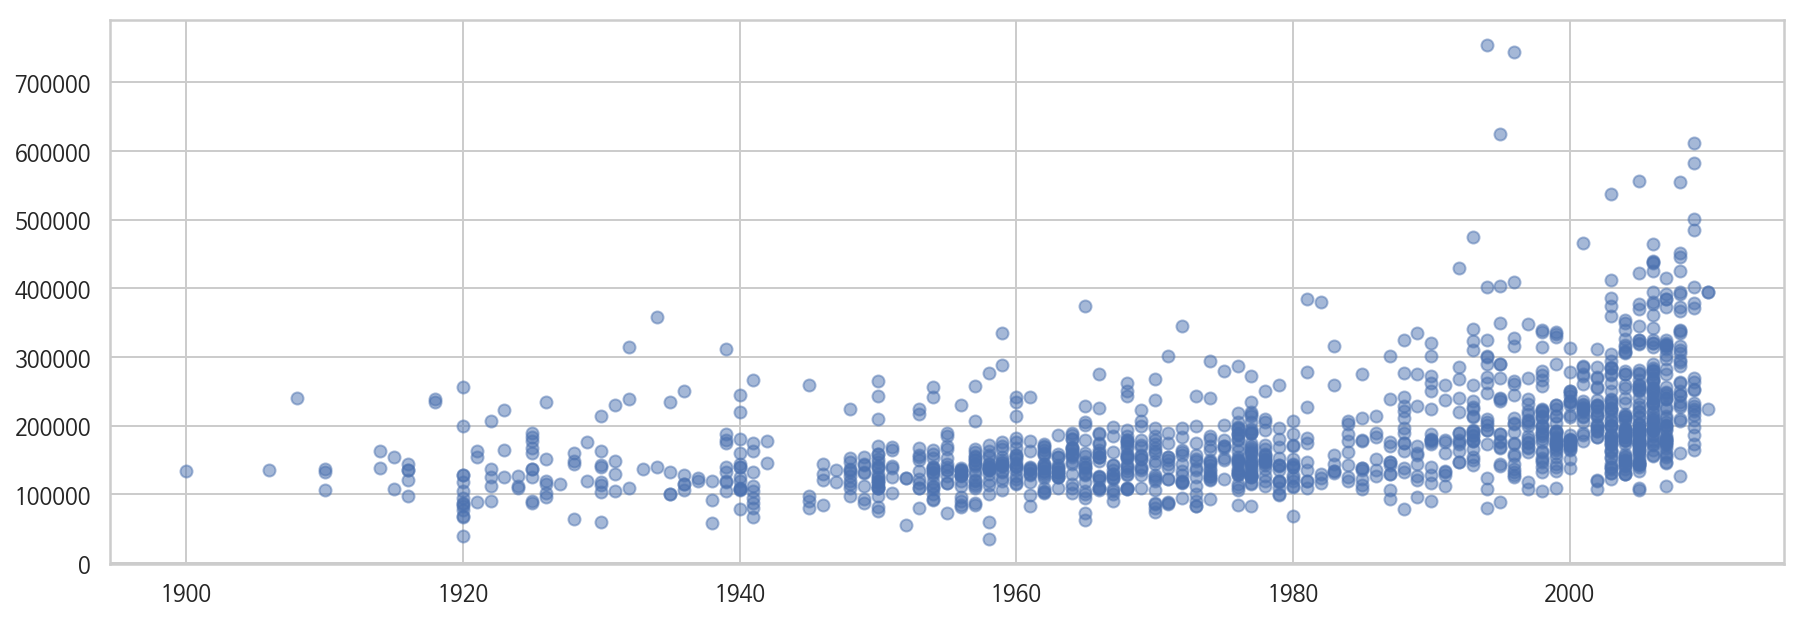

In [70]:
df['SalePrice'] = y
plt.figure(figsize=(15,5))
plt.scatter(x=df['GarageYrBlt'][df['GarageYrBlt']>1750], y=df['SalePrice'][df['GarageYrBlt']>1750], alpha=0.5)
df.drop('SalePrice',axis=1, inplace=True)

### Categorical 변수들을 더미로 변경

In [71]:
# 범주형 더미로 변경
df = pd.concat((df[col_quan], pd.get_dummies(df[col_cat], drop_first=True)), axis=1)

## OLS 회기분석

In [77]:
# 트레인셋 & 테스트셋 으로 분리
df_train, df_testset, y_train, y_test = train_test_split(df, y , train_size= 0.7, test_size = 0.3)

In [78]:
df_testset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438 entries, 1242 to 144
Columns: 264 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(2), int64(24), uint8(238)
memory usage: 194.2 KB


In [79]:
X = df_train
X = sm.add_constant(X)
Y = y_train
result = sm.OLS(Y,X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     44.26
Date:                Fri, 16 Aug 2019   Prob (F-statistic):               0.00
Time:                        20:07:42   Log-Likelihood:                -11564.
No. Observations:                1021   AIC:                         2.362e+04
Df Residuals:                     774   BIC:                         2.484e+04
Df Model:                         246                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -4.976e+

In [80]:
# 예측값 비교
X1 = df_testset
X1 = sm.add_constant(X1)
ypred = result.predict(X1)
predict_df = pd.DataFrame(ypred)
predict_df.rename(columns={0:'predict'}, inplace=True)
predict_df['SalePrice'] = y_test
predict_df.tail()

,predict,SalePrice
256,204979.703624,207500
1038,88791.611638,97000
403,271140.759015,258000
1405,288929.275489,275000
144,123389.183716,125000


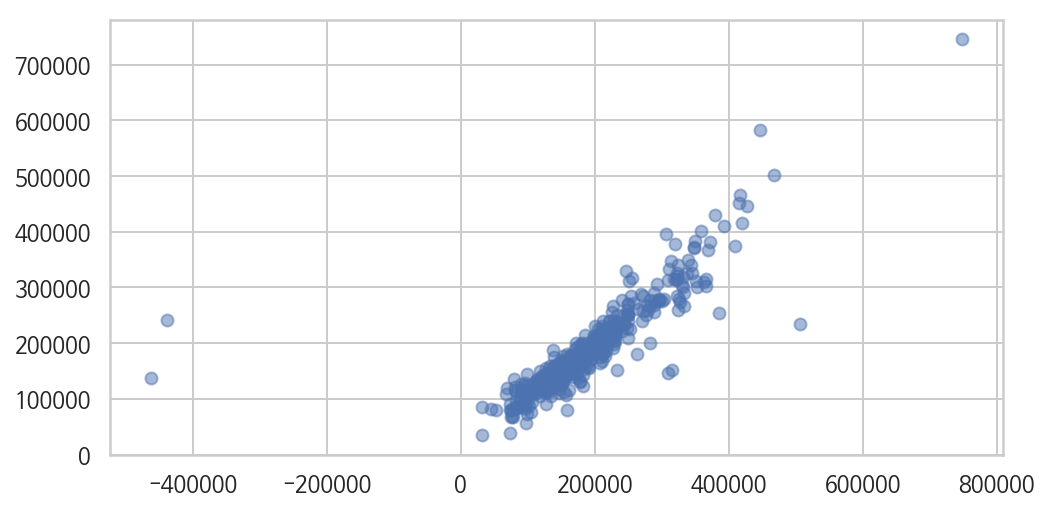

In [81]:
plt.figure(figsize=(8,4))
plt.scatter(x=predict_df['predict'], y=predict_df['SalePrice'],alpha=0.5)

In [82]:
# Kfold로 스코어 확인
score = 0 
cv = KFold(5, shuffle=True, random_state=0)
# cv.split()
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
    df_tra, df_tra_y = df.iloc[idx_train], y.iloc[idx_train]
    df_te, df_te_y = df.iloc[idx_test], y.iloc[idx_test]
    result_temp = sm.OLS(df_tra_y, df_tra).fit()
    yhat = result_temp.predict(df_te)
    temp_score = np.sqrt(mean_squared_error(df_te_y, yhat))
    score += temp_score
print(score/5)

73448.15919173983


## Ridge Regression

In [83]:
X = df_train
Y = y_train
rr = Ridge(alpha=10000).fit(pd.DataFrame(Y),X)
rr.score(pd.DataFrame(Y),X)

0.08462673027051733

In [84]:
rr001 = Ridge(alpha=0.01).fit(pd.DataFrame(Y),X)
rr001.score(pd.DataFrame(Y),X)

0.0846267302705172

In [85]:
lr = LinearRegression().fit(pd.DataFrame(Y),X)
lr.score(pd.DataFrame(Y),X)

0.08462673027051722

/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to NanumBarunGothic.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to NanumBarunGothic.
  (prop.get_family(), self.defaultFamily[fontext]))


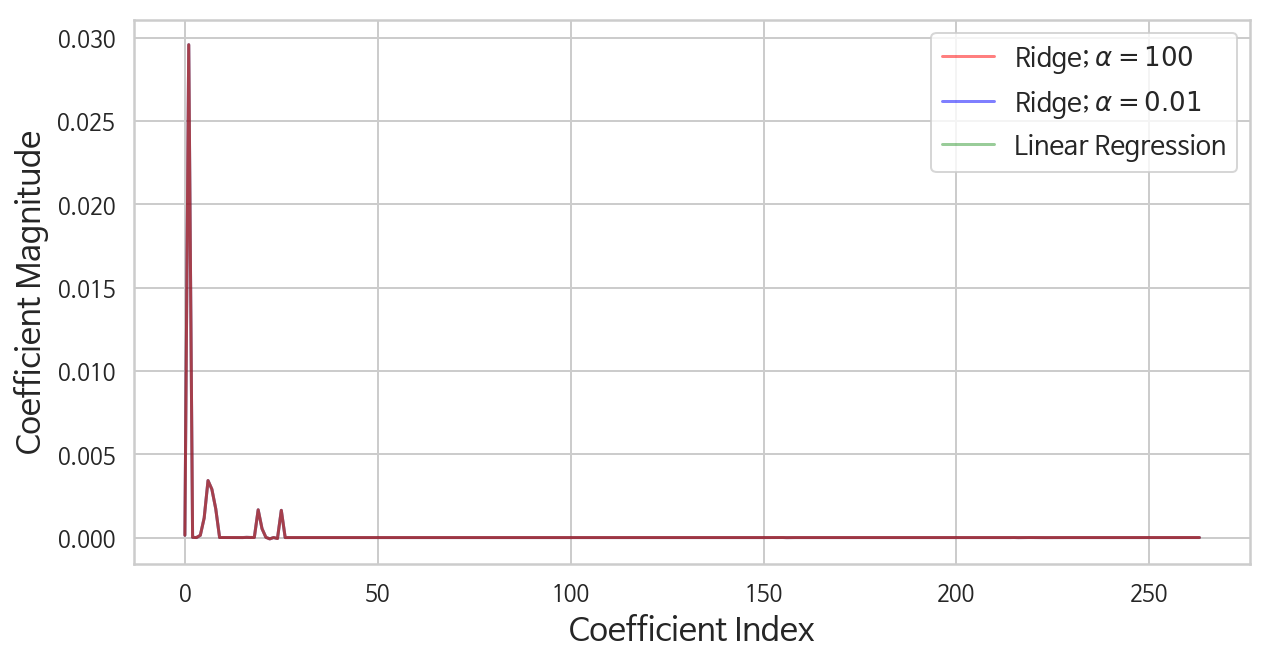

In [86]:
plt.figure(figsize=(10,5))
plt.plot(rr.coef_, alpha=0.5,color='red',label=r'Ridge; $\alpha = 100$',zorder=7) 
plt.plot(rr001.coef_, alpha=0.5,color='blue',label=r'Ridge; $\alpha = 0.01$') 
plt.plot(lr.coef_, alpha=0.4,color='green',label='Linear Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc='best')
plt.show()

## Lasso Regression

In [87]:
X = df_train
Y = y_train
lasso = Lasso(alpha=0.1).fit(pd.DataFrame(Y),X)
lasso.score(pd.DataFrame(Y),X)

/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordina

0.08462673027051526

In [88]:
lasso = Lasso(alpha=0.0000001).fit(pd.DataFrame(Y),X)
lasso.score(pd.DataFrame(Y),X)

/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247294.95504449308, tolerance: 20148.63647522037
  positive)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132122.74937182665, tolerance: 15152.236321253677
  positive)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27747.261341542006, tolerance: 19361.77843036239
  positive)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7585.6310286

0.0846267302705172

### OLS - Lasso, Ridge

In [89]:
X = df_train
X = sm.add_constant(X)
Y = y_train
result = sm.OLS(Y,X).fit_regularized(alpha=1e-10, L1_wt=1)
print(result.params)

const                    168252.014567
LotFrontage                  -2.996511
LotArea                       0.399943
OverallQual                5199.615741
OverallCond                -858.265335
YearRemodAdd                -14.727748
MasVnrArea                   28.895661
TotalBsmtSF                  26.656883
FstFlrSF                     14.401816
SndFlrSF                     59.997493
LowQualFinSF                  1.838988
BsmtFullBath              -1008.687683
BsmtHalfBath              -1705.176187
FullBath                  -5414.180247
HalfBath                  -6941.133619
BedroomAbvGr              -8969.236975
KitchenAbvGr             -28284.213289
TotRmsAbvGrd               4716.273802
Fireplaces                 7423.820708
GarageCars                 5334.734004
GarageArea                    2.473129
WoodDeckSF                    6.151263
PoolArea                    763.650872
MiscVal                      -4.341266
Porch                      2548.251167
YrMo                     

In [90]:
X1 = df_testset
X1 = sm.add_constant(X1)
ypred = result.predict(X1)
predict_df = pd.DataFrame(ypred)
predict_df.rename(columns={0:'predict'}, inplace=True)
predict_df['SalePrice'] = y_test
predict_df.tail()

,predict,SalePrice
256,204701.383011,207500
1038,91629.651745,97000
403,286851.005223,258000
1405,285724.859751,275000
144,90701.118501,125000


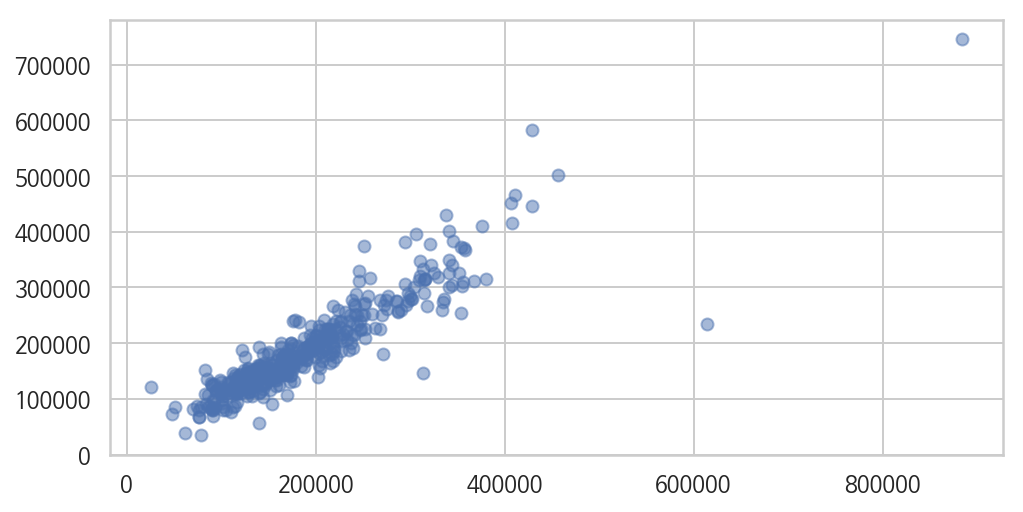

In [91]:
plt.figure(figsize=(8,4))
plt.scatter(x=predict_df['predict'], y=predict_df['SalePrice'],alpha=0.5)

## Kaggle Submission

In [92]:
kaggle =  pd.read_csv('/Users/lesson6_mac/Downloads/PersonalProject/houseprices/sample_submission.csv')
kaggle.tail()

,Id,SalePrice
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659
1458,2919,187741.866657


#### 테스트 파일 가져오기

In [93]:
df_test = pd.read_csv('/Users/lesson6_mac/Downloads/PersonalProject/houseprices/test.csv')
df_test.drop('Id', axis=1, inplace=True)

In [94]:
na_list2 = df_test[col_null]

# 테스트 데이터 NA 변경
Lot_col2 = df_test[['LotFrontage','LotArea']]
Lot_col2['Div'] = Lot_col2['LotArea']/Lot_col2['LotFrontage']
Lot_mean = Lot_col2['Div'].dropna()[Lot_col2['Div'].dropna() < 500].mean()
na_list2['LotFrontage'] = Lot_col2['LotFrontage'].fillna(Lot_col2['LotArea']/Lot_mean)
na_col2 = 'Alley'
na_list2[na_col2] = na_list2[na_col2].fillna('NoAcss')
na_col2 = 'MasVnrType'
na_list2[na_col2] = na_list2[na_col2].fillna('None')
na_col2 = 'MasVnrArea'
na_list2[na_col2] = na_list2[na_col2].fillna(0.0)
na_col2 = 'BsmtQual'
na_list2[na_col2] = na_list2[na_col2].fillna('NoBsmt')
na_col2 = 'BsmtCond'
na_list2[na_col2] = na_list2[na_col2].fillna('NoBsmt')
na_col2 = 'BsmtExposure'
na_list2[na_col2] = na_list2[na_col2].fillna('NoBsmt')
na_col2 = 'BsmtFinType1'
na_list2[na_col2] = na_list2[na_col2].fillna('NoBsmt')
na_col2 = 'BsmtFinType2'
na_list2[na_col2] = na_list2[na_col2].fillna('NoBsmt')
na_col2 = 'Electrical'
na_list2[na_col2] = na_list2[na_col2].fillna('None')
na_col2 = 'FireplaceQu'
na_list2[na_col2] = na_list2[na_col2].fillna('NoF')
na_col2 = 'GarageType'
na_list2[na_col2] = na_list2[na_col2].fillna('NoGrage')
na_col2 = 'GarageYrBlt'
na_list2[na_col2] = na_list2[na_col2].fillna('NoGrage')
na_col2 = 'GarageFinish'
na_list2[na_col2] = na_list2[na_col2].fillna('NoGrage')
na_col2 = 'GarageQual'
na_list2[na_col2] = na_list2[na_col2].fillna('NoGrage')
na_col2 = 'GarageCond'
na_list2[na_col2] = na_list2[na_col2].fillna('NoGrage')
na_col2 = 'PoolQC'
na_list2[na_col2] = na_list2[na_col2].fillna('NoPool')
na_col2 = 'Fence'
na_list2[na_col2] = na_list2[na_col2].fillna('NoFnc')
na_col2 = 'MiscFeature'
na_list2[na_col2] = na_list2[na_col2].fillna('Nothing')
# df_test 으로 NA값 정리한 데이터 이동
for i in col_null:
    df_test[i] = na_list2[i]
# GarageYrBlt 컬럼의 NA값을 0을로 바꾸고 타입을 Int로 한후 연속형 변수로 변환
df_test['GarageYrBlt'] = np.where(df_test['GarageYrBlt'] == 'NoGrage', 0, df_test['GarageYrBlt'])
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].astype(int)
# MSSubClass 컬럼 변경
df_test['MSSubClass'] = np.select([df_test['MSSubClass']==20,
                                   df_test['MSSubClass']==30,df_test['MSSubClass']==40,
                                   df_test['MSSubClass']==45,df_test['MSSubClass']==50,
                                   df_test['MSSubClass']==60,df_test['MSSubClass']==70,
                                   df_test['MSSubClass']==75,df_test['MSSubClass']==80,
                                   df_test['MSSubClass']==85,df_test['MSSubClass']==90,
                                   df_test['MSSubClass']==120,df_test['MSSubClass']==150,
                                   df_test['MSSubClass']==160,df_test['MSSubClass']==180,
                                   df_test['MSSubClass']==190,], ['S1NEW', 'S1OLD', 'S1FA', 'S1hUFA', 'S1hFA', 'S2NEW', 'S2OLD',
                                                                    'S2h', 'SML', 'SF', 'DPL', 'S1PNEW', 'S1hSP', 'S2PNEW', 'PMI', 'F2'])
# 컬럼이름이 숫자로 시작하는 컬럼 이름을 영문으로 시작하도록 변경
df_test.rename(columns={'1stFlrSF':'FstFlrSF','2ndFlrSF':'SndFlrSF'}, inplace=True)
# 컬럼별 수정
df_test = df_test.drop('YearBuilt', axis=1)
df_test = df_test.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], axis=1)
df_test = df_test.drop(['GrLivArea'], axis=1)
MVT_index = df_test[df_test['MasVnrType'] == 'None'][['MasVnrType','MasVnrArea']][df_test[df_test['MasVnrType'] == 'None']['MasVnrArea']!=0].index
df_test.loc[MVT_index,'MasVnrArea'] = 0.0
df_test['Porch'] = np.where(((df_test['OpenPorchSF'] !=0) | (df_test['EnclosedPorch'] !=0) | (df_test['3SsnPorch']!=0) | (df_test['ScreenPorch'] != 0)), 1, 0)
df_test.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch' ,'ScreenPorch'], axis=1, inplace=True)
df_test['MoSold'] = np.where(df_test['MoSold'].astype(int) < 10, '0'+df_test['MoSold'].astype(str), df_test['MoSold'].astype(str))
df_test['YrMo'] = df_test['YrSold'].map(str) + df_test['MoSold']
df_test['YrMo'] = df_test['YrMo'].astype(int)
df_test.drop(['YrSold', 'MoSold'], axis=1, inplace= True)


# 범주형 더미로 변경
df_test = pd.concat((df_test[col_quan], pd.get_dummies(df_test[col_cat], drop_first=True)), axis=1)

In [95]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 246 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(7), int64(19), uint8(220)
memory usage: 609.9 KB


In [103]:
# Nan값 찾기
nan_columns = []
for i in df_test.columns:
    if df_test[i].isna().any():
        nan_columns.append(i)
nan_columns

['TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']

In [105]:
# Nan값 0으로 채우기
df_test = df_test.fillna(0)


In [106]:
listlist = []
for i in df.columns:
    if not i in df_test.columns:
        listlist.append(i)
for j in listlist:
    df_test[j] = 0
df_test.drop('MSSubClass_S1hSP', axis=1, inplace=True)

In [109]:
# OLS-Lasso 모델로 예측
X1 = df_test
X1 = sm.add_constant(X1)
pred_kaggle = result.predict(X1)
pred_kaggle

0       275530.938730
1       110645.954102
2       129611.598115
3       174629.744546
4       180167.603784
5       147475.068237
6       127527.269117
7       151601.569015
8       147069.253977
9       177211.786172
10      168494.835028
11      179279.307299
12      171373.515227
13      215323.868508
14      187684.544530
15      313380.627090
16      265447.850893
17      283712.092350
18      270113.582917
19      352507.095056
20      244712.542156
21      225272.487372
22      140106.640933
23      165098.098694
24       78460.249449
25      105567.273240
26      182090.514328
27      236661.704359
28      138253.390263
29      163955.712501
            ...      
1429     87113.871059
1430    164906.658619
1431     16269.920449
1432    -53182.955107
1433     55625.007734
1434    217588.918607
1435    204780.106879
1436    139400.374480
1437    119853.050500
1438    182798.372144
1439    191639.714700
1440   -299597.196725
1441    239319.958597
1442    329279.930259
1443    28

In [108]:
df_test.iloc[[660,728,1116, 1117]]

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,TotalBsmtSF,FstFlrSF,SndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,PoolArea,MiscVal,Porch,YrMo,GarageYrBlt,MSSubClass_F2,MSSubClass_PMI,MSSubClass_S1FA,MSSubClass_S1NEW,MSSubClass_S1OLD,MSSubClass_S1PNEW,MSSubClass_S1hFA,MSSubClass_S1hUFA,MSSubClass_S2NEW,MSSubClass_S2OLD,MSSubClass_S2PNEW,MSSubClass_S2h,MSSubClass_SF,MSSubClass_SML,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_NoAcss,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBsmt,BsmtQual_TA,BsmtCond_Gd,BsmtCond_NoBsmt,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBsmt,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBsmt,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBsmt,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasW,Heating_Grav,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoF,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGrage,GarageFinish_NoGrage,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Gd,GarageQual_NoGrage,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NoGrage,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Gd,PoolQC_NoPool,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NoFnc,MiscFeature_Nothing,MiscFeature_Othr,MiscFeature_Shed,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Utilities_NoSeWa,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,HouseStyle_2.5F

In [110]:
kaggle['SalePrice'] = pred_kaggle

In [111]:
kaggle.to_csv('submission.csv', index=False)